# Segmentation Example
This notebook gives an example of how to use [pyshepseg](https://www.pyshepseg.org) to segment an image of any size, extract statistics associated with the segments and create a vector version of the output.

You'll need to install both [RIOS](https://www.rioshome.org/en/latest/#downloads) and [pyshepseg](https://www.pyshepseg.org/en/latest/#installation) to make this work, ideally in a new environment.

Note that there seems to be a bug in the statistics generation that I think is related to the use of JPEG compression in tiff files. If statistics are not generated, try first translating the image using something like:
```
gdal_translate -of GTiff -co COMPRESS=DEFLATE -co TILED=YES -co BIGTIFF=YES INFILE_COMPRESSTED_WITH_JPEG.tif OUTFILE_COMPRESSED_WITH_DEFLATE.tif
```

To run this it might be useful to set up a new environment
f you're new to this, I'd recommend starting with [Miniconda](https://docs.conda.io/en/latest/miniconda.html) then installing the required packages in a new environment. I'd also recommend replacing conda with mamba to speed up the solving of python dependencies. Something like this should work:
```
conda create --name seg python=3.9
conda activate seg 
conda install -c conda-forge mamba
mamba install -c conda-forge jupyterlab rios gdal numpy numba pip scikit-learn
```

Then either use the copy of pyshepseg in this repo, or (much) better install it using the [install directions](https://www.pyshepseg.org/en/latest/#installation) on the pyshepseg website.

In [1]:

# First we import the required packages
import os
import numpy as np
import matplotlib.pyplot as plt
from pyshepseg import shepseg
from pyshepseg import tiling
from pyshepseg import utils
from rios import applier
from rios import rat
from rios import ratapplier
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
import joblib


# Utility function to get the nodata vaues of a raster
def getNodata(raster):
    raster = gdal.Open(raster)
    band = raster.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    return nodata


# Filenames used in this notebook
RASTER = '14MAY28105005-S3DS-subset.tif'
LAYERNAME=os.path.splitext(os.path.basename(RASTER))[0]
OUTFILE = LAYERNAME + '.kea'
RGBFILE = LAYERNAME + '_rgb.tif'
IDFILE = LAYERNAME + '_id.tif'
SEGFILE = LAYERNAME + '_seg.gpkg'
CSVFILE = LAYERNAME + '_rat.csv'

# Get the NoData value of the input file
noData = getNodata(RASTER)

## Run the tiled segmenter
This takes a while to run, and the initiAL KMEANs clustering can take hours for large images.

The process works by segmenting tiles. These need to be small enough to fit in memory, with enough overlap so they stitch together neatly at the end.

There are quite a few options that control the segmentation, in particular minSegmentSize is the minimum segment size (in pixels) which will be left after eliminating small segments (except for segments which cannot be eliminated) and maxSpectralDiff sets a limit on how different segments can be and still be merged. It is given in the units of the spectral space of img. If maxSpectralDiff is ‘auto’, a default value will be calculated from the spectral distances between cluster centres, as a percentile of the distribution of these (spectDistPcntile). The value of spectDistPcntile should be lowered when segementing an image with a larger range of spectral distances. If fourConnected is True, then use 4-way connectedness when clumping, otherwise use 8-way connectedness. Default values are mostly as suggested by Shepherd et al.

By default this writes a [KEA](http://www.kealib.org/) format image, as we make extensive use of the raster attribute table to store data.

After the segmentation, we also calculate histograms and some statistics on the segment IDs



In [2]:

TILE_SIZE = 4096 # Set this so the tiles fit in memory
OVERLAP_SIZE = TILE_SIZE // 16
MIN_PIXELS = 10000 # Minimum number of pixels in a segment to be considered a valid segment = 2500 m2

# Run the tiles segmentation
tiledSegResult = tiling.doTiledShepherdSegmentation(RASTER, OUTFILE, 
        tileSize=TILE_SIZE, overlapSize=OVERLAP_SIZE, 
        minSegmentSize=MIN_PIXELS, numClusters=60,
        bandNumbers=None, subsamplePcnt=1,
        maxSpectralDiff='auto', imgNullVal=noData,
        fixedKMeansInit=False, spectDistPcntile=50,
        fourConnected=True, verbose=True,
        simpleTileRecode=False, outputDriver='KEA')


# Build the histogram, segment stats and colour table on the KEA file. 
outDs = gdal.Open(OUTFILE, gdal.GA_Update)
# This builds the histogram of segmentIDs
hist = tiling.calcHistogramTiled(outDs, tiledSegResult.maxSegId, writeToRat=True)
# This gets the band object representing the segmentIDs
band = outDs.GetRasterBand(1)
# This adds metadata back into the KEA file making it easier to open and view
utils.estimateStatsFromHisto(band, hist)
# Uncomment this to write a random color table to the KEA file
#utils.writeRandomColourTable(band, tiledSegResult.maxSegId+1)

# Close the KEA file
del outDs

Starting tiled segmentation
KMeans of whole raster 6.01 seconds
Subsample Percentage=1.00
Found 2 tiles, with 1 rows and 2 cols

Doing tile 1 of 2: row=0, col=0
Kmeans, in 0.7 seconds
Found 11364647 clumps, in 1.2 seconds
Eliminated 8157153 single pixels, in 2.3 seconds
Eliminated 3205868 segments, in 268.0 seconds
Final result has 1626 segments

Doing tile 2 of 2: row=0, col=1
Kmeans, in 0.9 seconds
Found 14718709 clumps, in 0.7 seconds
Eliminated 10485658 single pixels, in 2.0 seconds
Eliminated 4229150 segments, in 337.1 seconds
Final result has 3901 segments
Stitching tiles together
Stitching tile row 0


## Generate Zonal Statistics 
The calcPerSegmentStatsTiled is a very efficient way to calculate various statistics for each segment.

A routine is provided to do this in a memory-efficient way, given the original image and the completed segmentation image. 

A standard set of statistics are available, including mean, standard deviation, and arbitrary percentile values, amongst others. 

The selected per-segment statistics are written to the segment image file as columns of a raster attribute table (RAT).




In [3]:
# Build the RGB Stats from the input image
for imgbandnum in [1,2,3]:
    statsSelection = [
        ('band_{}_mean'.format(imgbandnum), 'mean'),  # Calculate the mean per segment
        ('band_{}_std'.format(imgbandnum), 'stddev')] # Calculate the standard deviation per segment
    tiling.calcPerSegmentStatsTiled(RASTER, imgbandnum, OUTFILE,statsSelection)


## Export the segment ID and the segment means to GeoTiff images 
This uses the RIOS library to link the segment ID to the corresponding KEA file

In [4]:
# Setup the RIOS inputs and Outputs
infiles = applier.FilenameAssociations()
outfiles = applier.FilenameAssociations()   
infiles.image = OUTFILE
outfiles.id = IDFILE
outfiles.rgb = RGBFILE

# Other inputs include the columns representing the mean values 
otherargs = applier.OtherInputs()
otherargs.b1 = np.round(rat.readColumn(OUTFILE,'band_1_mean')).astype(np.uint16)
otherargs.b2 = np.round(rat.readColumn(OUTFILE,'band_2_mean')).astype(np.uint16)
otherargs.b3 = np.round(rat.readColumn(OUTFILE,'band_3_mean')).astype(np.uint16)
otherargs.noData = noData

# Set up RIOS controls
controls = applier.ApplierControls()
controls.windowxsize = 512
controls.windowysize = 512
controls.setStatsIgnore(noData)
controls.setOutputDriverName("GTIFF")
controls.setCreationOptions(["COMPRESS=DEFLATE",
                             "ZLEVEL=9",
                             "BIGTIFF=YES",
                             "TILED=YES",
                             "INTERLEAVE=BAND",
                             "NUM_THREADS=ALL_CPUS",
                             "BLOCKXSIZE=512",
                             "BLOCKYSIZE=512"])

# Function applied on image tiles using RIOS applier to extract the segment means
def _exportColor(info,inputs,outputs,otherargs):   
    # Get the input segment IDs
    data = inputs.image
    # Get the input array shape
    inshape = data.shape
    # Flatten the segment id array
    data = np.reshape(data,-1)
    # Use the segment ids as keys into the band mean attributes
    b1 = (otherargs.b1)[data]
    b2 = (otherargs.b2)[data]
    b3 = (otherargs.b3)[data]
    # Stack the segmtn means into a three band image
    rgb = np.vstack((b1,b2,b3))
    # Reshape the outputs to match the input shape
    outputs.id =  np.reshape(data,(1,inshape[1],inshape[2])).astype(np.uint32)
    outputs.rgb =  np.reshape(rgb,(3,inshape[1],inshape[2])).astype(np.uint16)

# Apply the function
applier.apply(_exportColor, infiles, outfiles, otherargs, controls=controls)



## Build a vector file
Sometimes you might want to vectorize the output.

This is a much faster version of [gdal_polygonize.py](https://gdal.org/programs/gdal_polygonize.html) as it writes the entire file in one transaction.

In [5]:
# Open the Raster
outDs = gdal.Open(IDFILE)
band = outDs.GetRasterBand(1)
# Create the vector
vecDs = ogr.GetDriverByName("GPKG").CreateDataSource(SEGFILE)
vecLayer = vecDs.CreateLayer('segid', srs=osr.SpatialReference(wkt=outDs.GetProjection()))
vecLayer.CreateField(ogr.FieldDefn('segid', ogr.OFTInteger))
# Polygonize
vecDs.StartTransaction()
gdal.Polygonize( band, None, vecLayer, 0, [], callback=None)
vecDs.CommitTransaction()
# Close the raster and vector
del outDs
del vecDs


## Cluster the Raster Attributes
This is a simple example of how to use KMeans on the raster attributes to cluster the segments. This is a simple example, and you might want to use something more sophisticated from [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html) or [hdbscan](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html).


In [2]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

# Get the column names
colNames = rat.getColumnNames(OUTFILE)
# Print the column names
print(colNames)


['Histogram', 'band_1_mean', 'band_1_std', 'band_2_mean', 'band_2_std', 'band_3_mean', 'band_3_std']


### Select the attributes you want to use for clustering
Here I am just selecting the means, but feel free to use any of the attributes in the RAT or even add additional attributes using band ratios etc.

In [3]:
wantedAttributes = ['band_1_mean', 'band_2_mean', 'band_3_mean']

# Read the data into an array
clusterData  = np.transpose([rat.readColumn(OUTFILE,name) for name in wantedAttributes])
# Drop the first row, as it contains the nodata
clusterData = clusterData[1:]
# Lets add a ratio index to the data as an example. We also add a small value to avoid divide by zero errors
someRatioIndex = (clusterData [:,2]-clusterData [:,1])/(clusterData [:,0]+clusterData [:,1]+clusterData [:,2]+np.finfo(float).eps)
# Add the ratio index to the data
clusterData  = np.concatenate((clusterData ,someRatioIndex[:,None]),axis=1)
# Print an example of the data
print(clusterData [:,:5])

[[ 3.41250000e+01  3.91250000e+01  3.31250000e+01 -5.64042303e-02]
 [ 9.25084076e+01  9.53276367e+01  8.20668640e+01 -4.91316407e-02]
 [ 4.16428566e+01  4.68214302e+01  3.92857132e+01 -5.89880001e-02]
 ...
 [ 4.73333321e+01  4.53333321e+01  4.16666679e+01 -2.72952667e-02]
 [ 7.67931061e+01  6.70344849e+01  6.03448257e+01 -3.27647546e-02]
 [ 5.75000000e+01  4.75000000e+01  4.83333321e+01  5.43477436e-03]]


### Prepare the data for clustering
Here we scale the data using a robust scaler, which is a good idea for spectral data. 

Following this, we calculate the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a range of cluster numbers. This is a good way to determine the number of clusters to use.


2 18562.604143156223 0.43391574510207803
3 11329.789676022145 0.5520509513640687
4 9207.519491114133 0.537925008391546
5 6380.425283216004 0.5823735736863163
6 6102.309135353617 0.3457782355354981
7 5700.949615790718 0.3275002212817844
8 4240.606423521874 0.5427036637207542
9 4387.704580338179 0.3528230708308147
10 3396.1338614101023 0.37017988235977184
11 3728.1150615203546 0.38998147968828606
12 3176.1412049637242 0.3726730077632537
13 2175.6806548340037 0.40133455536992396
14 1904.2244224134845 0.3443067101400719
15 2977.338603023128 0.32033107253499604
16 1340.0472134015827 0.36444175651706995
17 1667.2040270110758 0.38495177424197274
18 1458.2703988269213 0.32211217201298453
19 1401.101781705855 0.3333811798174915
20 1157.1330042135007 0.3316016435725043
21 1111.3384002947341 0.3427141821742927
22 1044.4148494337314 0.3438984700663941
23 1128.7411775379055 0.3705372031415461
24 1708.1811624724357 0.32889358502914123


Text(0.5, 0, 'Number of clusters')

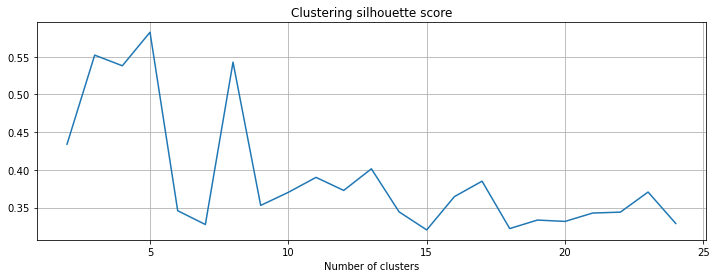

In [46]:
# Scale the data
clusterData = RobustScaler().fit_transform(clusterData)

# Sample the data to reduce the number of points
MAX_TESTING_POINTS = 5000
sampleSize = min(MAX_TESTING_POINTS,clusterData.shape[0])
sampleIdx = np.random.choice(clusterData.shape[0],sampleSize,replace=False)


# Find the optimal number of clusters
inertia = []
silhouette = []
nclasses = range(2,25)
for c in nclasses:
    kmeans = MiniBatchKMeans(n_clusters=c).fit(clusterData[sampleIdx])
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(clusterData[sampleIdx], kmeans.labels_))
    print(c,inertia[-1],silhouette[-1])

# Plot the silhouette score
plt.figure(figsize=(12,4))
plt.plot(nclasses, silhouette)
plt.grid()
plt.title('Clustering silhouette score')
plt.xlabel('Number of clusters')

### Cluster the complete dataset using a selected number of clusters
Select the number of clusters you think is useful, and then cluster the data.

In [49]:
OPTIMAL_NUM_CLUSTERS = 15
# Cluster the full dataset
kmeans = MiniBatchKMeans(n_clusters = OPTIMAL_NUM_CLUSTERS).fit(clusterData)
# Get the cluster labels and add one to avoid zero values
clusterLabels = kmeans.labels_ + 1
# Add back in the first row of nodata
clusterLabels = np.insert(clusterLabels,0,0)

## Extract the raster attributes into a CSV file
This is a utility function that just pulls the raster attributes into a simple CSV file that you can then join to the vector file in a GIS.

The linking attribute is the segid, which is the same as the segid in the vector file. See the animated gif in the readme for an example of how to do this in QGIS.

In [50]:
# Get the column names
colNames = rat.getColumnNames(OUTFILE)
# Read the data into an array
allData = np.transpose([rat.readColumn(OUTFILE,name) for name in colNames])
# Add an index column
allData = np.vstack((np.arange(len(allData)),allData.T)).T
# Add the kmeans labels
allData = np.vstack((allData.T,clusterLabels)).T
# Make a header
colNames.insert(0,'segid')
colNames.append('kmeans_label')
header = ','.join(colNames)
# Write the file
np.savetxt(CSVFILE,allData,fmt='%8.3f',delimiter=',',header=header,comments='')
